In [2]:
# GPU availability
import tensorflow as tf
print('tf version {}'.format(tf.__version__))
print('Is GPU available {}'.format(tf.test.is_gpu_available()))
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))

tf version 1.13.1
Is GPU available False


In [3]:
# gym specifications
import gym
import time 
env_name = 'CartPole-v0'
env_name = 'Breakout-v0'
env_name = 'Pong-v0'
env = gym.make(env_name)
print(env_name)
print('observation dimensionality {}'.format(env.observation_space.shape ))
print('number of actions {}'.format(env.action_space.n))
print('meaning of actions {}'.format(env.unwrapped.get_action_meanings()))

Pong-v0
observation dimensionality (210, 160, 3)
number of actions 6
meaning of actions ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [51]:
# Train a model
%load_ext autoreload
%autoreload 2
import gym
import os
import matplotlib 
%matplotlib inline
from model import Model
from cfg import get_cfg
from utils import get_experiment_name
from utils import dotdict
import tensorflow as tf
tf.reset_default_graph()

# where to save experimental results
experiments_folder = os.path.join(os.getcwd(), 'results')
experiment_name, experiment_folder = get_experiment_name(experiments_folder)

# specify environment
env_name = 'four_rooms_maze'
env_name = 'BreakoutNoFrameskip-v4'
env_name = 'CartPole-v0'
env_name = 'PongNoFrameskip-v4'

# specify agent
agent_name = 'vpg'
agent_name = 'ppo'
agent_name = 'dqn'

# load default config parameters
cfg_env, cfg_agent = get_cfg(experiment_folder, env_name, agent_name)
cfg = cfg_env
cfg.update(cfg_agent)
cfg = dotdict(cfg)

# modify default config parameters
cfg.n_steps = 100
cfg.batch_size = 1
cfg.log_step = 10
cfg.agent_buffer_start_size = 50
cfg.save_freq = 200
cfg.verbose = False

# train model
model = Model(cfg)
model.train_model()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ep 1 st 10 dqn e.ret.tr 0.00 ep.ln 0 sp 0.0 ag.ls 0.00 eps 1.00 
ep 1 st 20 dqn e.ret.tr 0.00 ep.ln 0 sp 547.0 ag.ls 0.00 eps 1.00 
ep 1 st 30 dqn e.ret.tr 0.00 ep.ln 0 sp 533.8 ag.ls 0.00 eps 1.00 
ep 1 st 40 dqn e.ret.tr 0.00 ep.ln 0 sp 677.6 ag.ls 0.00 eps 1.00 
ep 1 st 50 dqn e.ret.tr 0.00 ep.ln 0 sp 689.7 ag.ls 0.00 eps 1.00 
ep 1 st 60 dqn e.ret.tr 0.00 ep.ln 0 sp 15.1 ag.ls 0.00 eps 1.00 
ep 2 st 70 dqn e.ret.tr -1.00 ep.ln 64 sp 22.2 ag.ls 0.00 eps 1.00 
ep 2 st 80 dqn e.ret.tr -1.00 ep.ln 64 sp 14.6 ag.ls 0.00 eps 1.00 
ep 2 st 90 dqn e.ret.tr -1.00 ep.ln 64 sp 18.6 ag.ls 0.00 eps 1.00 
ep 2 st 100 dqn e.ret.tr -1.00 ep.ln 64 sp 7.8 ag.ls 0.00 eps 1.00 


In [61]:
# Load pretrained model
%load_ext autoreload
%autoreload 2
import os
from model import Model
import tensorflow as tf
tf.reset_default_graph()

dpath = os.path.join(os.getcwd(), 'results_train/dqn/Model')
model = Model.load(dpath)

# continue training
#model.train_model()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:tensorflow:Restoring parameters from /Users/raoul/code/drl/results_train/dqn/Model/dqn_ckpt-147500


INFO:tensorflow:Restoring parameters from /Users/raoul/code/drl/results_train/dqn/Model/dqn_ckpt-147500


In [62]:
# Simulate episodes in OpenAI gym
import time 
import matplotlib
%matplotlib inline
n_steps, n_plays, rewards = 0, 0, []
for _ in range(1000):
    obs, ext_return, done = model.env.reset(), 0., False
    while not done:
        obs = model.encode_obs(obs)
        action = model.action(obs, 0.)
        obs, r, done, info = model.env.step(action)
        rewards.append(r)
        n_steps += 1
        #if n_steps % 4 == 0:
        #    model.env.render('gif/{}.png'.format(1000 + n_steps))
        #time.sleep(0.01)
    n_plays += 1
pos_reward_ratio = sum([r for r in rewards if r > 0]) / n_plays
print(n_plays, n_steps, pos_reward_ratio)
model.env.close()

1000 95904 1.0


In [6]:
# Make gif
import os 
import imageio
images = []
experiment_folder = os.path.join(os.getcwd(), 'gif')
fnames = os.listdir(experiment_folder)
fnames = sorted([fname for fname in fnames if '.png' in fname])
for fname in fnames:
    fname = os.path.join(experiment_folder, fname)
    images.append(imageio.imread(fname))
imageio.mimsave('gif/pong_not_preprocessed.gif', images, duration=0.20)

In [59]:
# Tensorflow events to csv files
from utils import tf_events_to_csv
from utils import subdir_paths
experiment_folder = os.path.join(os.getcwd(), 'results_train/dqn')
for dpath in subdir_paths(experiment_folder):
    tf_events_to_csv(dpath)

<Figure size 432x288 with 0 Axes>

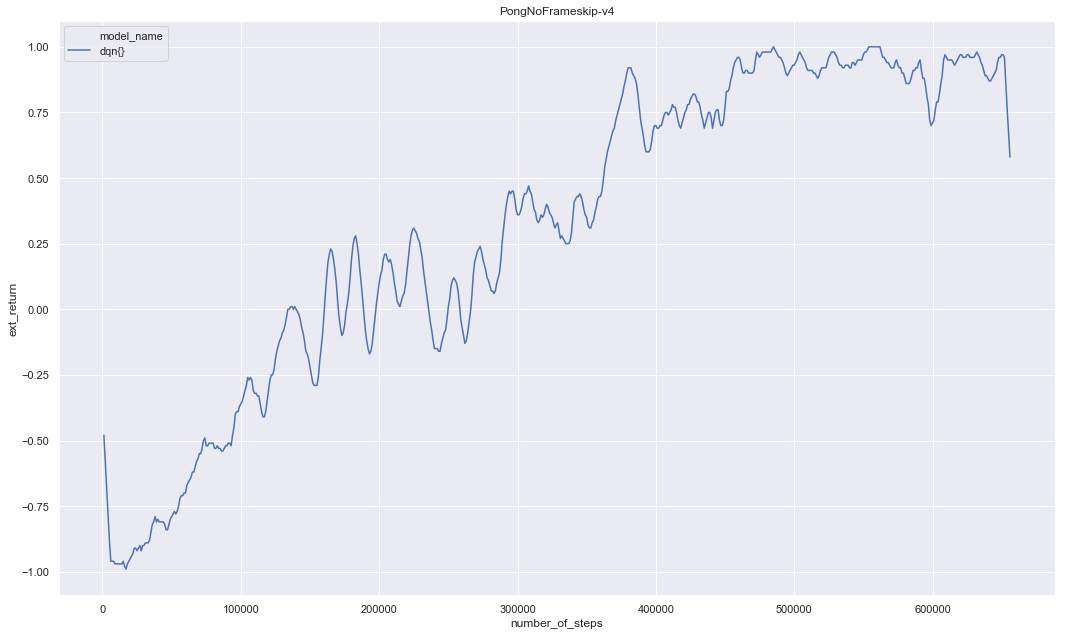

In [60]:
# Hyperparameter Plots
import os
from utils import plot_hp_sensitivities
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

experiment_folder = os.path.join(os.getcwd(), 'results_train/dqn')
plot_hp_sensitivities(experiment_folder, 'ext_return', 'model_name',{}, details=False, box_pts=10, show=True)